1. Setup, Load, & Tema Visual Global

In [1]:
# 09_robustness.ipynb — ROBUSTNESS & SENSITIVITY
# -----------------------------------------------------------------------
# Objectives:
# - Pearson vs Spearman + CI (Fisher & Bootstrap)
# - Rolling windows sensitivity (w ∈ {3,6,9,12})
# - Lead–lag (cross-correlation) for lag k ∈ {−3..+3}
# - Outlier influence: 1% winsorization and jackknife Δr
#
# References:
# - SciPy: pearsonr, spearmanr
# - Bootstrap paired-resampling (Efron; simple implementation)
# - Jackknife leave-one-out (Tukey)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

# Paths
PROC = Path("data/processed")
FIG  = Path("reports/figures"); FIG.mkdir(parents=True, exist_ok=True)
TBL  = Path("reports/tables");  TBL.mkdir(parents=True, exist_ok=True)

# Color-blind friendly palette + global style
CBLUE   = "#2F4B7C"
CORANGE = "#F28E2B"
CGREEN  = "#59A14F"
CRED    = "#E15759"
CGREY   = "#9D9D9D"

mpl.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 140,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
    "font.size": 11,
})

# Load monthly log-returns (from step 05/08)
ret = (
    pd.read_csv(PROC/"monthly_returns_gold_btc_2020_2025.csv", parse_dates=["Date"])
      .set_index("Date").sort_index()[["Gold_ret","BTC_ret"]]
)

# Minimum QC
ret = ret.replace([np.inf, -np.inf], np.nan).dropna()
assert len(ret) >= 24, "Too few observations for robustness; check step 07/08."
n = len(ret)
print(f"N months: {n} | Range: {ret.index.min().date()} → {ret.index.max().date()}")

N months: 66 | Range: 2020-02-29 → 2025-07-31


2. Pearson (Fisher & Bootstrap CI) + Spearman

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_correlation.csv


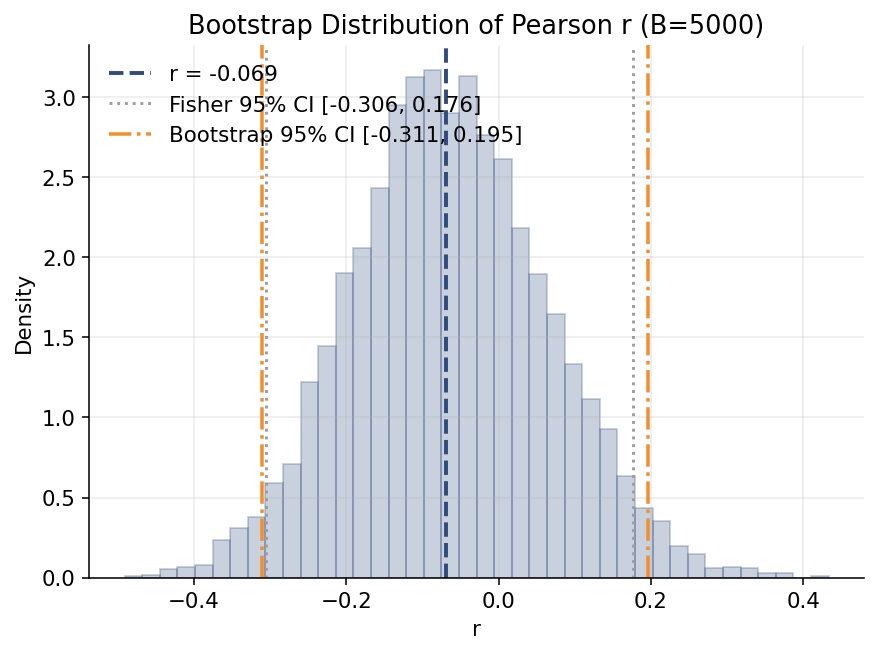

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\bootstrap_corr_hist.png


In [2]:
# Pearson r & p-value
r, p = stats.pearsonr(ret["Gold_ret"], ret["BTC_ret"])

# Fisher r-to-z 95% CI
z  = np.arctanh(np.clip(r, -0.999999, 0.999999))
se = 1/np.sqrt(n-3)
zcrit = stats.norm.ppf(1-0.05/2)
f_lo, f_hi = np.tanh([z - zcrit*se, z + zcrit*se])

# Nonparametric bootstrap CI
def bootstrap_corr(x: pd.Series, y: pd.Series, B=5000, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(x))
    xv, yv = x.to_numpy(), y.to_numpy()
    rs = np.empty(B, dtype=float)
    for b in range(B):
        s = rng.choice(idx, size=len(idx), replace=True)
        rs[b] = np.corrcoef(xv[s], yv[s])[0, 1]
    lo, hi = np.percentile(rs, [2.5, 97.5])
    return rs, float(lo), float(hi)

rs, b_lo, b_hi = bootstrap_corr(ret["Gold_ret"], ret["BTC_ret"])

# Spearman (monotonic)
rho, p_s = stats.spearmanr(ret["Gold_ret"], ret["BTC_ret"], nan_policy="omit")

# Save table
pd.DataFrame([{
    "n_months": n,
    "pearson_r": r, "pearson_p": p,
    "fisher_ci_lo": f_lo, "fisher_ci_hi": f_hi,
    "boot_ci_lo": b_lo, "boot_ci_hi": b_hi,
    "spearman_rho": rho, "spearman_p": p_s
}]).round(6).to_csv(TBL/"robustness_correlation.csv", index=False)
print("Saved →", (TBL/"robustness_correlation.csv").resolve())

# Plot: Bootstrap distribution + CI overlays
fig, ax = plt.subplots()
ax.hist(rs, bins=40, density=True, color=CBLUE, alpha=0.25, edgecolor=CBLUE)
ax.axvline(r,    color=CBLUE,  ls="--", lw=2,  label=f"r = {r:.3f}")
ax.axvline(f_lo, color=CGREY,  ls=":",  lw=1.5, label=f"Fisher 95% CI [{f_lo:.3f}, {f_hi:.3f}]")
ax.axvline(f_hi, color=CGREY,  ls=":",  lw=1.5)
ax.axvline(b_lo, color=CORANGE,ls="-.", lw=1.8, label=f"Bootstrap 95% CI [{b_lo:.3f}, {b_hi:.3f}]")
ax.axvline(b_hi, color=CORANGE,ls="-.", lw=1.8)
ax.set_title("Bootstrap Distribution of Pearson r (B=5000)")
ax.set_xlabel("r"); ax.set_ylabel("Density")
ax.legend(loc="upper left")
plt.tight_layout(); plt.savefig(FIG/"bootstrap_corr_hist.png"); plt.show()
print("Saved →", (FIG/"bootstrap_corr_hist.png").resolve())


3. Sensitivitas Window & Lead–lag (–3 … +3)

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_rolling_windows.csv | C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_crosscorr_lags.csv


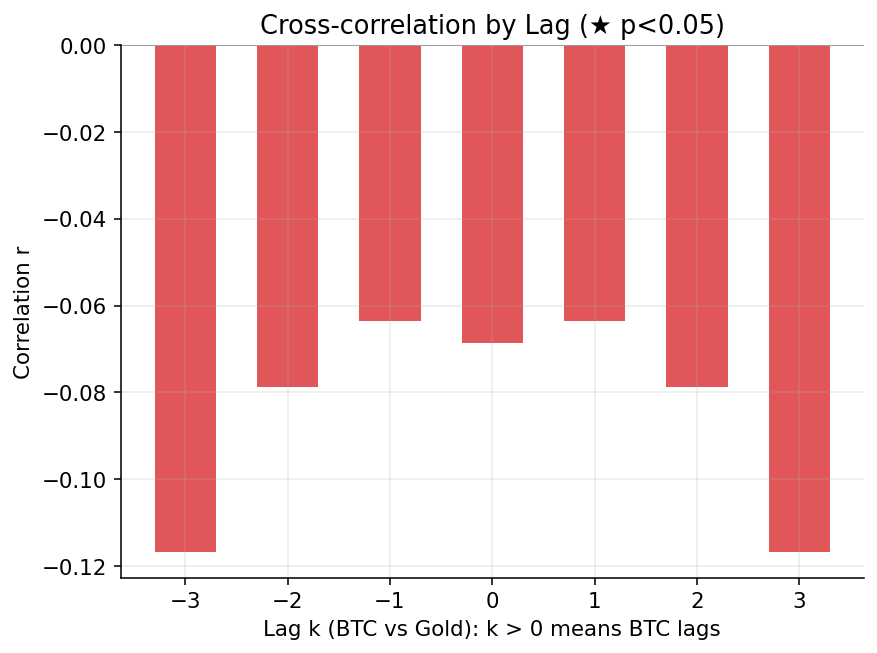

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\crosscorr_lags.png


In [3]:
# Rolling windows summary
rows=[]
for w in (3,6,9,12):
    roll = ret["Gold_ret"].rolling(w).corr(ret["BTC_ret"])
    rows.append({
        "window": w,
        "mean": float(roll.mean()),
        "min":  float(roll.min()),
        "max":  float(roll.max()),
        "frac_negative": float(roll.lt(0).mean())
    })
pd.DataFrame(rows).round(6).to_csv(TBL/"robustness_rolling_windows.csv", index=False)

# Cross-correlation by lag (k>0: BTC lags Gold by k months)
lag_rows=[]
for k in range(-3, 4):
    if k >= 0:
        x = ret["Gold_ret"].iloc[k:]
        y = ret["BTC_ret"].iloc[:len(ret)-k]
    else:
        k2 = -k
        x = ret["Gold_ret"].iloc[:len(ret)-k2]
        y = ret["BTC_ret"].iloc[k2:]
    df_xy = pd.concat([x, y], axis=1).dropna()
    if len(df_xy) >= 3:
        rr, pp = stats.pearsonr(df_xy.iloc[:,0], df_xy.iloc[:,1])
        lag_rows.append({"lag_btc_vs_gold": k, "n": len(df_xy), "r": rr, "p_value": pp})

lags_tab = pd.DataFrame(lag_rows).round(6)
lags_tab.to_csv(TBL/"robustness_crosscorr_lags.csv", index=False)
print("Saved →", (TBL/"robustness_rolling_windows.csv").resolve(), "|", (TBL/"robustness_crosscorr_lags.csv").resolve())

# Plot: cross-correlation bars + significance stars
pos = lags_tab["r"] >= 0
colors = np.where(pos, CGREEN, CRED)

fig, ax = plt.subplots()
ax.bar(lags_tab["lag_btc_vs_gold"], lags_tab["r"], color=colors, width=0.6)
ax.axhline(0, color=CGREY, lw=1)

for _, row in lags_tab.iterrows():
    if row["p_value"] < 0.05:
        y = row["r"] + (0.03 if row["r"] >= 0 else -0.05)
        va = "bottom" if row["r"] >= 0 else "top"
        ax.text(row["lag_btc_vs_gold"], y, "★", ha="center", va=va, fontsize=11)

ax.set_xlabel("Lag k (BTC vs Gold): k > 0 means BTC lags")
ax.set_ylabel("Correlation r")
ax.set_title("Cross-correlation by Lag (★ p<0.05)")
plt.tight_layout(); plt.savefig(FIG/"crosscorr_lags.png"); plt.show()
print("Saved →", (FIG/"crosscorr_lags.png").resolve())


4. Outlier Influence: Winsorize 1% & Jackknife + Summary

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_outliers_influence.csv | C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_jackknife_all.csv


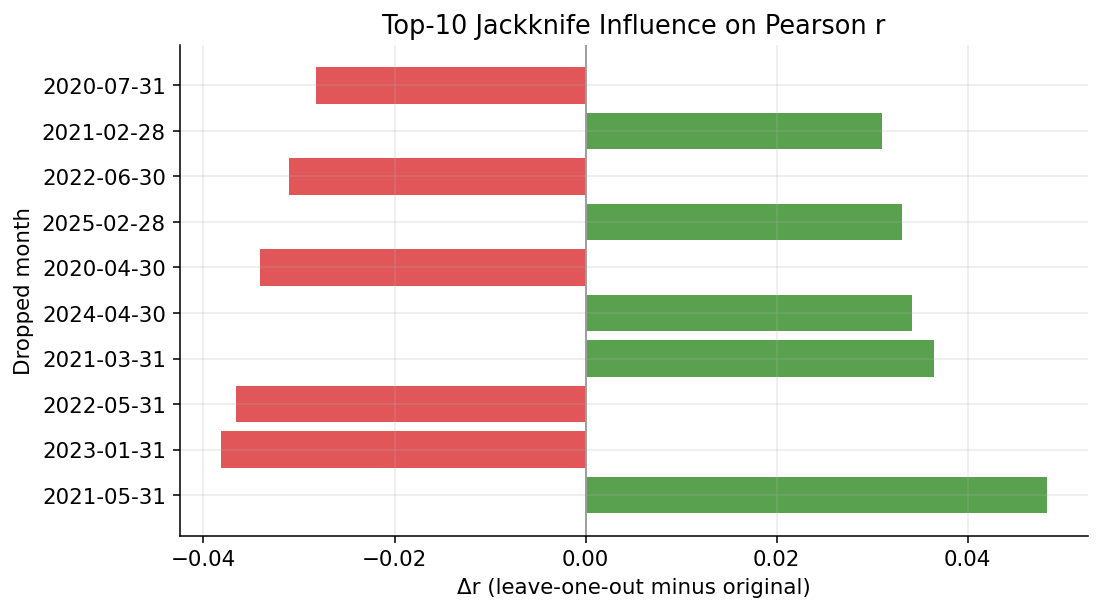

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\jackknife_top10.png
Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_summary.md


In [4]:
def winsorize(s: pd.Series, q: float = 0.01) -> pd.Series:
    lo, hi = s.quantile(q), s.quantile(1-q)
    return s.clip(lo, hi)

# Winsorize 1%
ret_w = ret.assign(
    Gold_ret = winsorize(ret["Gold_ret"]),
    BTC_ret  = winsorize(ret["BTC_ret"])
)
r_w, p_w = stats.pearsonr(ret_w["Gold_ret"], ret_w["BTC_ret"])

# Jackknife (leave-one-month-out)
jk_rows=[]
for ts in ret.index:
    sub = ret.drop(index=ts)
    if len(sub) >= 3:
        r_i, _ = stats.pearsonr(sub["Gold_ret"], sub["BTC_ret"])
        jk_rows.append({"drop_month": ts.date(), "r_without": r_i, "delta": r_i - r})
jk = pd.DataFrame(jk_rows).sort_values("delta")

# Save summaries
pd.DataFrame([{
    "pearson_r_original": r,
    "pearson_r_winsor1pct": r_w,
    "delta_winsor": r_w - r,
    "jackknife_min_r": jk["r_without"].min(),
    "jackknife_max_r": jk["r_without"].max(),
    "jackknife_min_delta": jk["delta"].min(),
    "jackknife_max_delta": jk["delta"].max()
}]).round(6).to_csv(TBL/"robustness_outliers_influence.csv", index=False)
jk.round(6).to_csv(TBL/"robustness_jackknife_all.csv", index=False)
print("Saved →", (TBL/"robustness_outliers_influence.csv").resolve(), "|", (TBL/"robustness_jackknife_all.csv").resolve())

# Plot: Top-10 most influential months (|Δr|)
top = jk.reindex(jk["delta"].abs().sort_values(ascending=False).index[:10]).copy()
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.barh(top["drop_month"].astype(str),
        top["delta"],
        color=np.where(top["delta"] >= 0, CGREEN, CRED))
ax.axvline(0, color=CGREY, lw=1)
ax.set_xlabel("Δr (leave-one-out minus original)")
ax.set_ylabel("Dropped month")
ax.set_title("Top-10 Jackknife Influence on Pearson r")
plt.tight_layout(); plt.savefig(FIG/"jackknife_top10.png"); plt.show()
print("Saved →", (FIG/"jackknife_top10.png").resolve())

# Compact Markdown summary for report (disimpan ke reports/tables/)
summary_md = f"""# Robustness Summary

**Sample**: N = {n} months ({ret.index.min().date()} → {ret.index.max().date()})

**Pearson r** = {r:.3f} (p = {p:.3f})  
Fisher 95% CI = [{f_lo:.3f}, {f_hi:.3f}]  
Bootstrap 95% CI = [{b_lo:.3f}, {b_hi:.3f}]

**Spearman ρ** = {rho:.3f} (p = {p_s:.3f})

**Winsorize 1%**: r = {r_w:.3f} (Δ vs original = {r_w - r:+.3f})  
**Jackknife** r_without ∈ [{jk['r_without'].min():.3f}, {jk['r_without'].max():.3f}]  
Top-10 influence plot: reports/figures/jackknife_top10.png

**Rolling windows** → reports/tables/robustness_rolling_windows.csv  
**Cross-corr (lags)** → reports/tables/robustness_crosscorr_lags.csv  
Figure: reports/figures/crosscorr_lags.png (★ p<0.05)
"""
md_path = TBL/"robustness_summary.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(summary_md)
print("Saved →", md_path.resolve())
